# Alpysbay Asset OPTION 1

In [1]:
print("Hello World")

Hello World


# Part 1. Library Installation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import (
    train_test_split,
    KFold, 
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    RocCurveDisplay,
    balanced_accuracy_score,
    classification_report
)

In [3]:
#set display max column to see all column
pd.set_option("display.max_columns", None)
pd.get_option("display.max_columns")

#set display max column to see all column
pd.set_option("display.max_rows", 150)
pd.get_option("display.max_rows")

150

The dataset consists of 10 000 data points stored as rows with 14 features in columns:

**UID**: unique identifier ranging from 1 to 10000

**product ID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high
(20%) as product quality variants and a variant-specific serial number

**air temperature [K]**: generated using a random walk process later normalized to a standard
deviation of 2 K around 300 K

**process temperature [K]**: generated using a random walk process normalized to a standard
deviation of 1 K, added to the air temperature plus 10 K.

**rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed
noise

**torque [Nm]**: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no
negative values.

**tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the
process. and a 'machine failure' label that indicates whether the machine has failed in this
particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

**tool wear failure (TWF)**: the tool will be replaced or fail at a randomly selected tool wear time
between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced
69 times, and fails 51 times (randomly assigned).

**heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference
between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is
below 1380 rpm. This is the case for 115 data points.

**power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power
required for the process. If this power is below 3500 W or above 9000 W, the process fails,
which is the case 95 times in our dataset.

**overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L
product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98
datapoints.

**random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process
parameters. This is the case for only 5 datapoints, less than could be expected for 10,000
datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label
is set to 1. It is therefore not transparent to the machine learning method, which of the failure
modes has caused the process to fail


# Part 2. Data Acquisition

This section covers the loading and initial inspection of the dataset.

In [4]:
df = pd.read_csv('Task1.csv')

In [5]:
print("\nDataset:")
display(df.head())
print("SHAPE:",df.shape)
#take a look on top of the dataset


Dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


SHAPE: (10000, 14)


In [6]:
df.info()
#Checking the types of the features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [7]:
#Displaying the dimensions of the dataframe
print(f"""
Size of Original Dataset
------------------------
Observations: {df.shape[0]}
Features:     {df.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 10000
Features:     14



In [8]:
#Checking is there are missing values in dataframe
df.isnull().any().any()

False

In [9]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [10]:
df.duplicated().sum()

0

In [11]:
# Product Type Categories and Counts
df.Type.value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

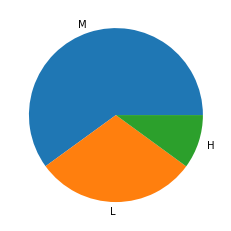

In [12]:
plt.pie(df.Type.value_counts(), labels = df.Type.unique())
plt.show()

In [13]:
# Binary Target Variable - Failure / No Failure
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [14]:
df['Machine failure'].value_counts() / len(df)

0    0.9661
1    0.0339
Name: Machine failure, dtype: float64

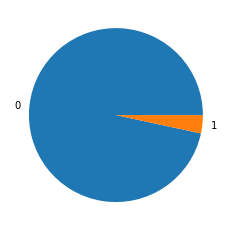

In [15]:
plt.pie(df['Machine failure'].value_counts(), labels = df['Machine failure'].unique())
plt.show()

In [16]:
counts = pd.concat([df['TWF'].value_counts(),
                   df['HDF'].value_counts(),
                   df['PWF'].value_counts(),
                   df['OSF'].value_counts(),
                   df['RNF'].value_counts()], axis=1)

print(counts)

    TWF   HDF   PWF   OSF   RNF
0  9954  9885  9905  9902  9981
1    46   115    95    98    19


**The Product ID column** contains unique identifiers for each entry in the dataframe, which do not provide useful information for predicting the tool's life. Therefore, it will be removed from the dataframe.

**The Type column** indicates the quality of the tool used, which is valuable information for predicting the tool's life. The remaining columns until the Target column contain relevant data about the working conditions of the tool, which are also useful for the prediction.

**The Machine failure column** indicates whether the tool has failed (Machine failure == 1) or not (Machine failure == 0). The Failure Type column provides the same information as the Target column, but in cases where there was a failure, it also specifies the type of failure the tool has experienced.

# Part 3. Data Visualization

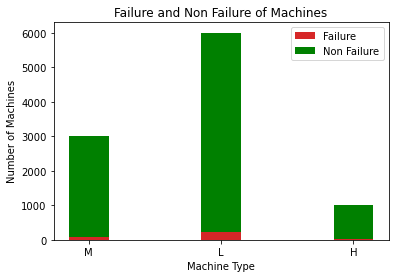

In [17]:
# Plot a bar chart showing machine which are Not Failed and Failed by Type of Machine
labels_Failed = ['M', 'L','H'] 
# Failure by Type
M_Failed = sum(df.loc[df['Type']=='M']['Machine failure'])
L_Failed = sum(df.loc[df['Type']=='L']['Machine failure'])
H_Failed = sum(df.loc[df['Type']=='H']['Machine failure'])
Failed=[M_Failed, L_Failed, H_Failed]

#Non failure by
M_Tot = len(df.loc[df['Type']=='M']['Machine failure'])
L_Tot = len(df.loc[df['Type']=='L']['Machine failure'])
H_Tot = len(df.loc[df['Type']=='H']['Machine failure'])

M_NF = M_Tot-M_Failed
L_NF = L_Tot-L_Failed
H_NF = H_Tot-H_Failed

NFail = [M_NF, L_NF, H_NF]

fig, ax = plt.subplots(1,1)
width = 0.3
ax.bar(labels_Failed, Failed, width, label='Failure',color='tab:Red')
ax.bar(labels_Failed, NFail, width, bottom=Failed,label='Non Failure',color='green')
ax.set_xlabel('Machine Type')
ax.set_ylabel('Number of Machines')
ax.set_title('Failure and Non Failure of Machines')
ax.legend()
plt.show()

In [18]:
print('Percentage of machines in Non Failure:',round((M_NF+L_NF+H_NF)*100/(M_Tot+L_Tot+H_Tot),1),'%')
print('Percentage of machines which had failure:',round((M_Failed+L_Failed+H_Failed)*100/(M_Tot+L_Tot+H_Tot),1),'%')

Percentage of machines in Non Failure: 96.6 %
Percentage of machines which had failure: 3.4 %


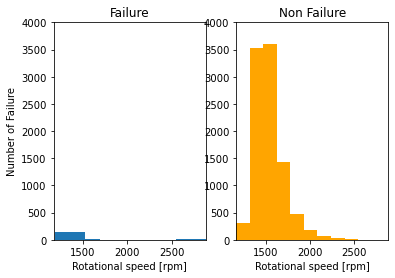

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df.loc[df['Machine failure'] == 1]['Rotational speed [rpm]'], color='tab:blue')
ax1.set_xlabel('Rotational speed [rpm]')
ax1.set_ylabel('Number of Failure')
ax1.set_title('Failure')

ax2.hist(df.loc[df['Machine failure'] == 0]['Rotational speed [rpm]'], color='orange')
ax2.set_xlabel('Rotational speed [rpm]')
ax2.set_title('Non Failure')

# Set the axis limits to be the same for both plots
xlimits = [df['Rotational speed [rpm]'].min(), df['Rotational speed [rpm]'].max()]
ylimits = [0, 4000]
ax1.set_xlim(xlimits)
ax1.set_ylim(ylimits)
ax2.set_xlim(xlimits)
ax2.set_ylim(ylimits)

plt.show()


In [20]:
df.drop(columns = ['Product ID'],inplace=True)

In [21]:
from sklearn.preprocessing import LabelEncoder
type_enc = LabelEncoder()
df['Type'] = type_enc.fit_transform(df['Type'])
#encoding 'Type' column to int values
df.head()

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


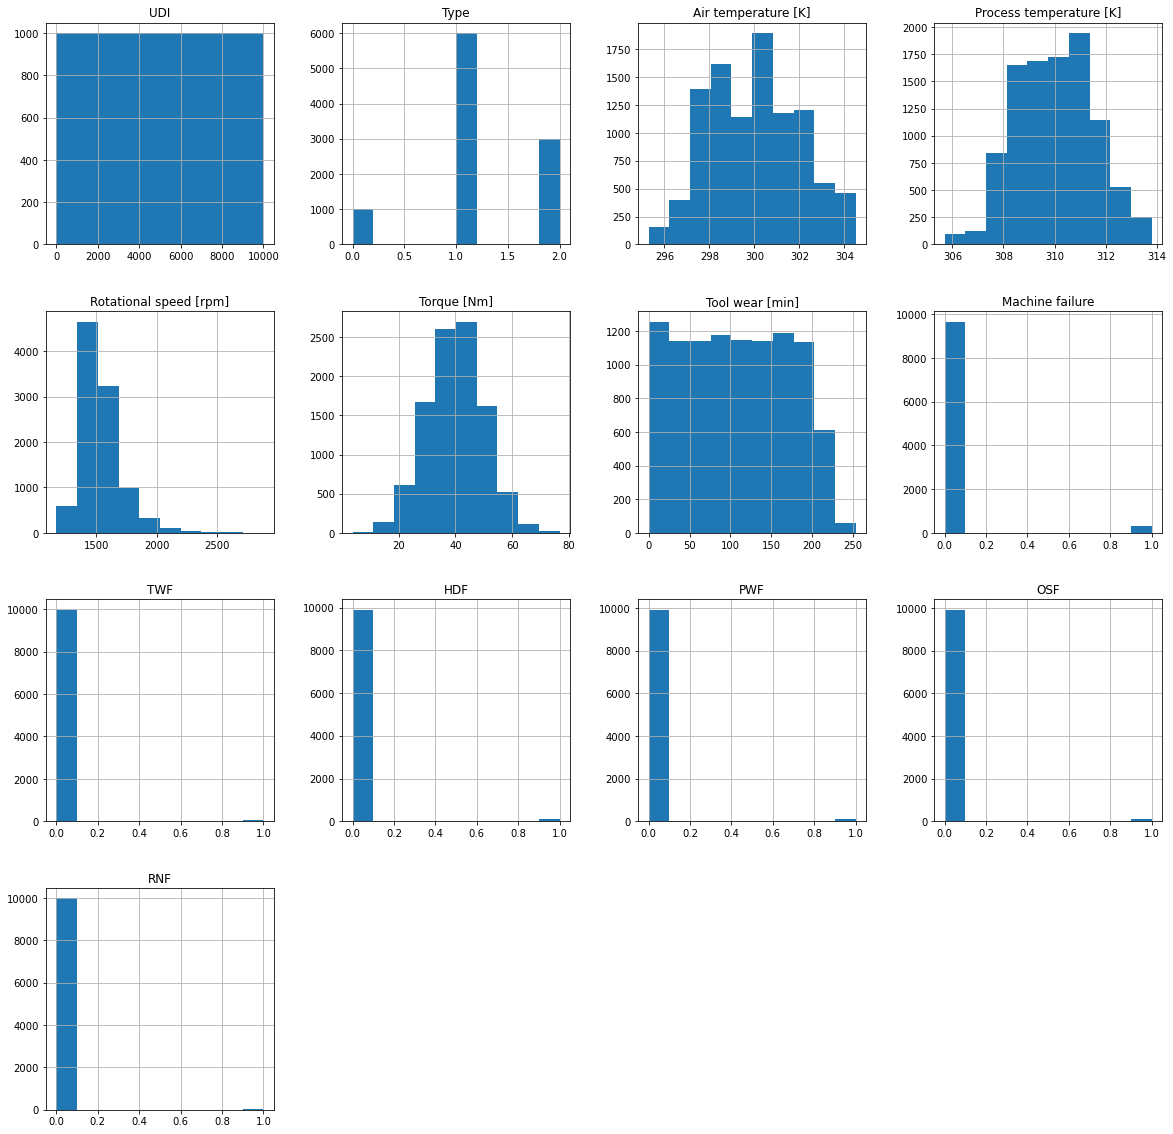

In [22]:
p = df.hist(figsize=(20, 20))

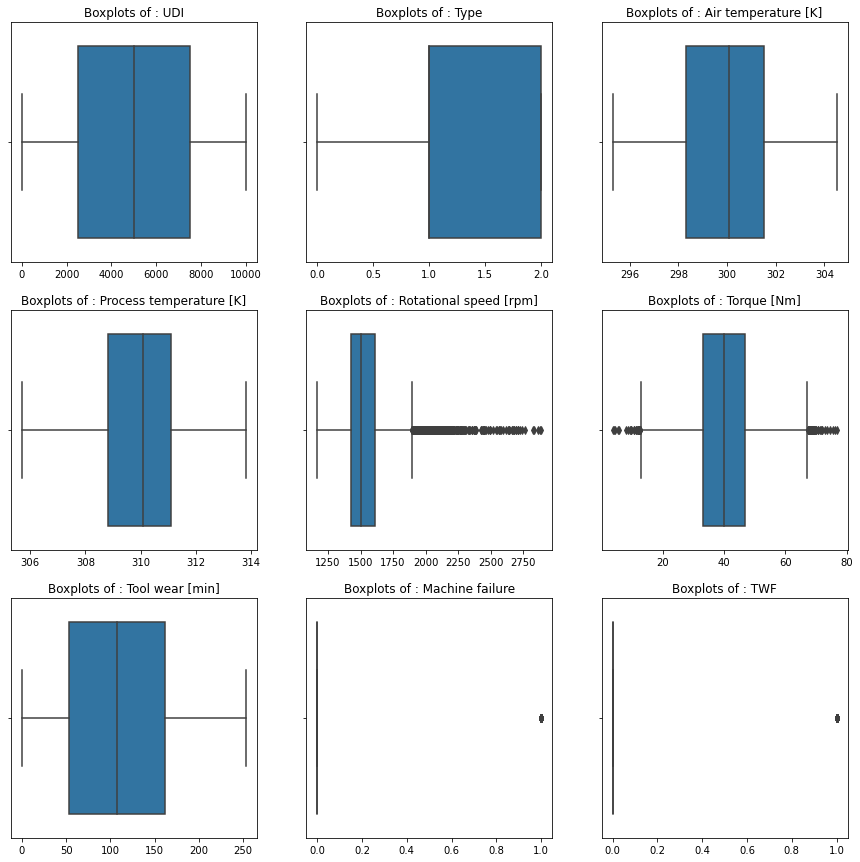

In [23]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
for i, ax in zip(df.columns, axes.flat):
    sns.boxplot(x=df[i], ax=ax).set(title=f"Boxplots of : {i}", xlabel="")
plt.show()

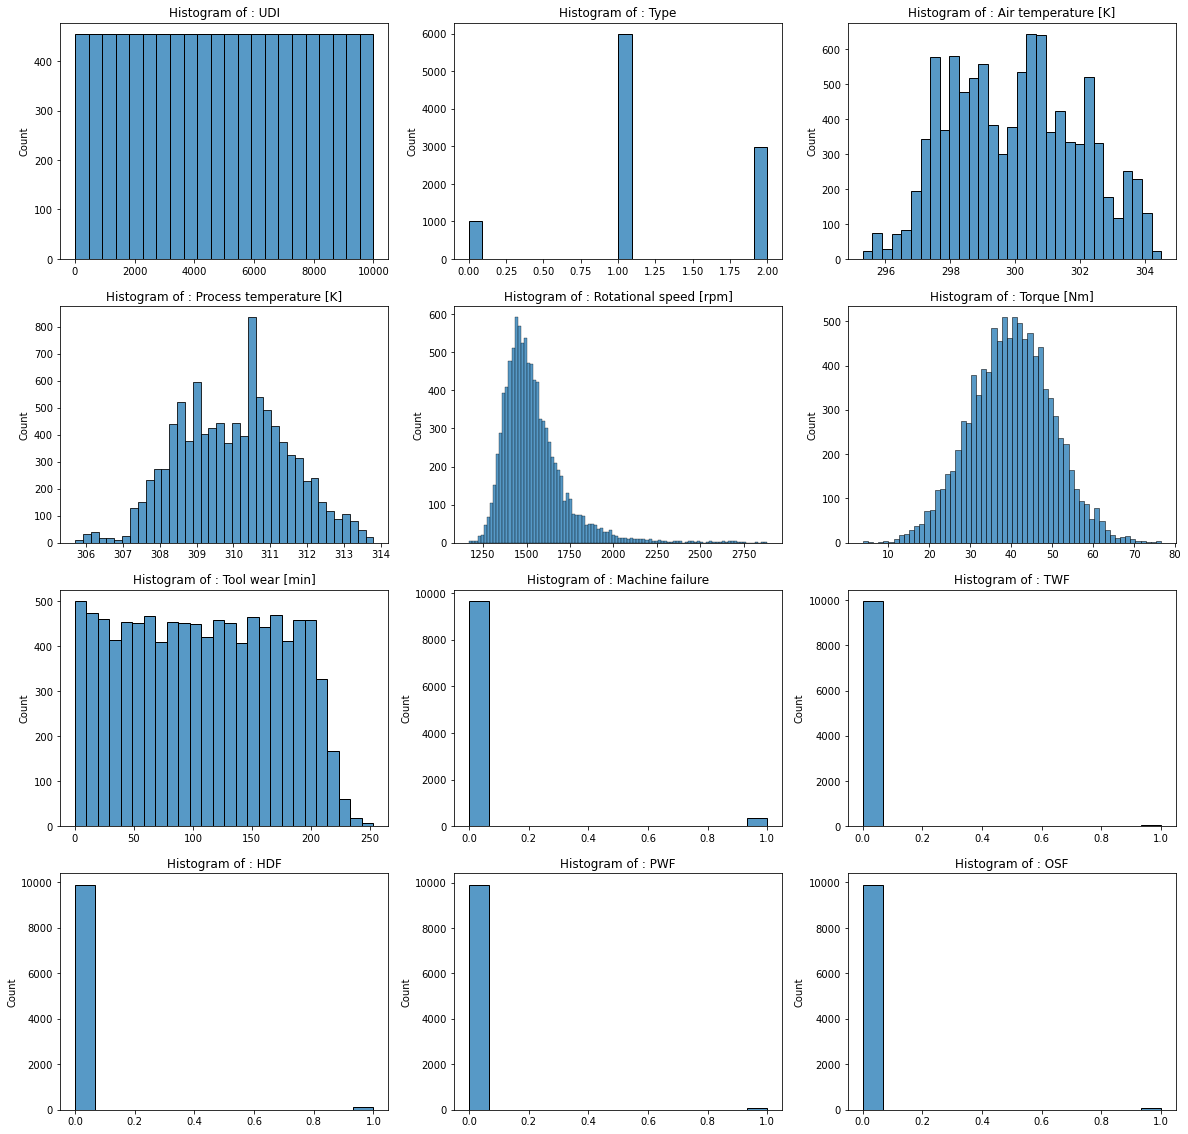

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20))
for i, ax in zip(df.columns, axes.flat):
    sns.histplot(x=df[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()


In [25]:
def show_category_distribution(data_frame, label_name, colors, exclude=[], figsize=(10, 5)):
    label_counts = data_frame[label_name].value_counts()
    label_counts = label_counts.drop(exclude)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    sns.countplot(data=data_frame, x=label_name, palette=colors, edgecolor="black", hatch="\\", ax=ax1)
    ax1.set_title(f"Distribution of \"{label_name}\"", size=14, fontweight="bold")
    ax1.set_xlabel("Class", size=10, fontweight="bold")
    ax1.set_ylabel("Frequency", size=10, fontweight="bold")
    ax1.tick_params(axis="x", labelsize=9) 
    ax1.tick_params(axis="y", labelsize=9)
    ax1.bar_label(ax1.containers[0], fmt="%.0f", color="black", fontsize=9)

    ax2.pie(label_counts, labels=label_counts.index, autopct="%1.2f%%", startangle=90, colors=colors)
    ax2.set_title(f"Distribution of \"{label_name}\". {'Excluded' if exclude else ''}", fontweight="bold", fontsize=14)

    plt.show()

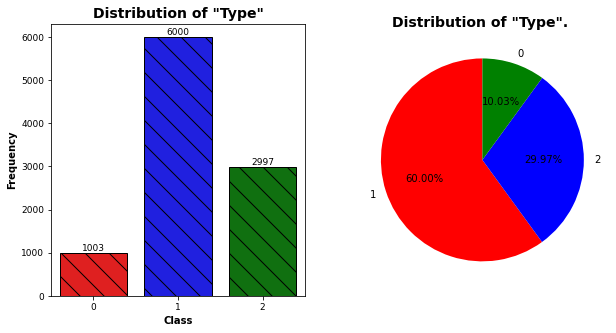

In [26]:
show_category_distribution(df,
                           "Type",
                           ["red", "blue", "green"])


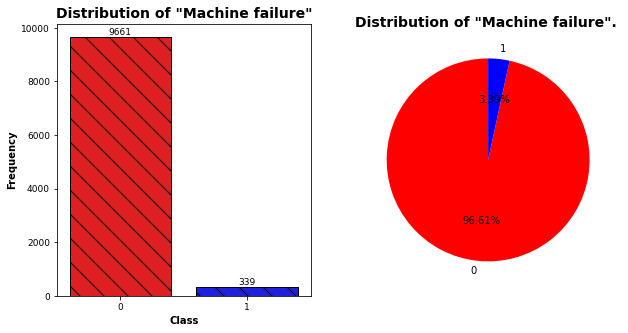

In [27]:
show_category_distribution(df,
                        "Machine failure",
                         ["red", "blue"])

In [28]:
corr = df.corr()
print(corr['Machine failure'].sort_values(ascending=False))

Machine failure            1.000000
HDF                        0.575800
OSF                        0.531083
PWF                        0.522812
TWF                        0.362904
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Process temperature [K]    0.035946
RNF                        0.004516
Type                      -0.005152
UDI                       -0.022892
Rotational speed [rpm]    -0.044188
Name: Machine failure, dtype: float64


In [29]:
df_selected = df[[
           
'Machine failure',      
'HDF',               
'OSF',          
'PWF',              
'TWF',            
'Torque [Nm]',                
'Tool wear [min]',     
'Air temperature [K]'             
    ]]
    

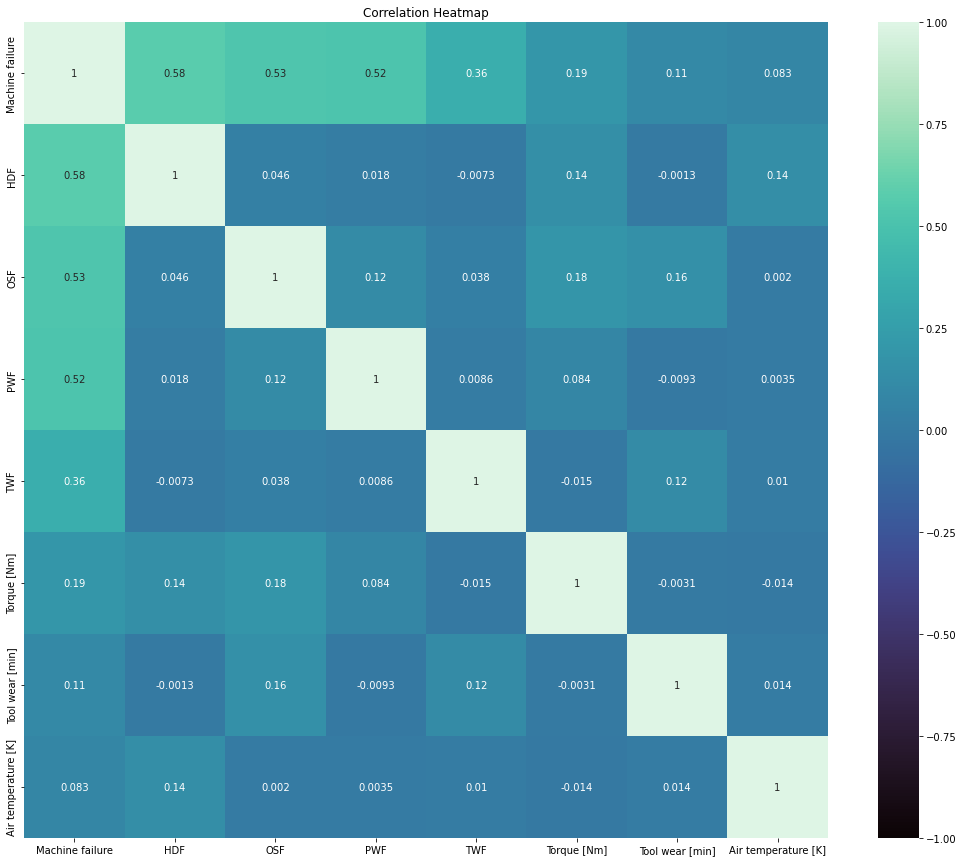

In [30]:
corr = df_selected.corr()

plt.figure(figsize=(18,15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()

We've selected only variables with a correlation above 0.05

# Model Preparation

In [31]:
X = df.drop('Machine failure',axis=True)
Y = df['Machine failure']

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=1/3,random_state=42, stratify=Y)

In our analysis, we will use several machine learning algorithms:

1. Logistic Regression
2. KNearest Neighbors
3. Super Vector Machine
4. Decision Tree
5. Random Forest
6. Gradient Boost

# Confusion Matrix

The confusion matrix function plays a vital role in evaluating the performance of our models. By defining this function, we can conveniently assess the accuracy of our model predictions. Additionally, the function allows us to calculate the balanced accuracy, which provides a reliable measure of overall model performance. The balanced accuracy considers the performance for each class individually, taking into account any class imbalances in the dataset. By leveraging the confusion matrix function, we can make informed decisions about model improvements and gauge the effectiveness of our classification models accurately.

In [42]:
def confusion_matrix_display(y_true, y_pred):
    print(f'Balanced accuracy score: {balanced_accuracy_score(y_true, y_pred)}')

    print(classification_report(y_true, y_pred))

    ax = plt.subplot()

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax)

    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    plt.show()

In [43]:
LR = LogisticRegression(solver='liblinear', class_weight='balanced')

param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

grid_lr = GridSearchCV(LR, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)
grid_lr.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=True)

In [44]:
grid_lr.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')

Balanced accuracy score: 0.9858716264497334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6440
           1       0.95      0.97      0.96       226

    accuracy                           1.00      6666
   macro avg       0.98      0.99      0.98      6666
weighted avg       1.00      1.00      1.00      6666



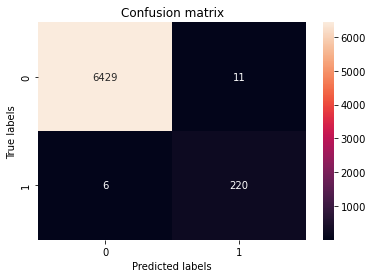

In [45]:
confusion_matrix_display(Y_train, grid_lr.predict(X_train))

Balanced accuracy score: 0.9857942759490401
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.95      0.97      0.96       113

    accuracy                           1.00      3334
   macro avg       0.97      0.99      0.98      3334
weighted avg       1.00      1.00      1.00      3334



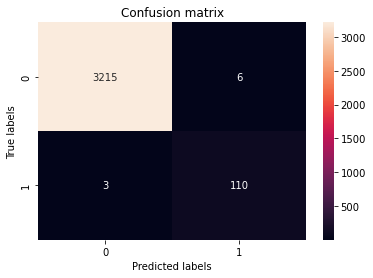

In [46]:
confusion_matrix_display(Y_test, grid_lr.predict(X_test))

The trained classification model demonstrates high performance on both the training and test datasets. The evaluation of model performance is based on multiple metrics that allow assessing accuracy, recall, precision, and overall effectiveness of the model.

For the training dataset:

The balanced accuracy score of the model is **0.9858716264497334**, indicating high performance in handling imbalanced classes.
The precision, recall, and f1-score metrics show high values for both classes, indicating the model's ability to classify training examples accurately.
The overall accuracy of the model is 1.00, indicating its high ability to correctly classify all examples in the training dataset.

For the test dataset:

The balanced accuracy score of the model is **0.9857942759490401**, indicating high performance in handling imbalanced classes.
The precision, recall, and f1-score metrics show high values for both classes, indicating the model's ability to classify test examples accurately.
The overall accuracy of the model is 1.00, indicating its high ability to correctly classify all examples in the test dataset.

The macro avg and weighted avg values of precision, recall, and f1-score for all classes indicate the overall good performance of the model on both the training and test datasets.

# 2. Decision Tree

Let's define print score for both our Decision Tree and Random Forest models.

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, Y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(Y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Balanced Accuracy Score: {balanced_accuracy_score(Y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix_display(Y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(Y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Balanced Accuracy Score: {balanced_accuracy_score(Y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix_display(Y_test, pred)}\n")

Train Result:
Balanced Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    6440.0  226.0       1.0     6666.0        6666.0
_______________________________________________
Balanced accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6440
           1       1.00      1.00      1.00       226

    accuracy                           1.00      6666
   macro avg       1.00      1.00      1.00      6666
weighted avg       1.00      1.00      1.00      6666



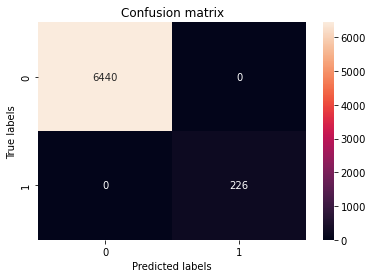

Confusion Matrix: 
 None

Test Result:
Balanced Accuracy Score: 98.66%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.999069    0.990991    0.9988     0.995030      0.998795
recall        0.999690    0.973451    0.9988     0.986570      0.998800
f1-score      0.999379    0.982143    0.9988     0.990761      0.998795
support    3221.000000  113.000000    0.9988  3334.000000   3334.000000
_______________________________________________
Balanced accuracy score: 0.9865704324221851
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.99      0.97      0.98       113

    accuracy                           1.00      3334
   macro avg       1.00      0.99      0.99      3334
weighted avg       1.00      1.00      1.00      3334



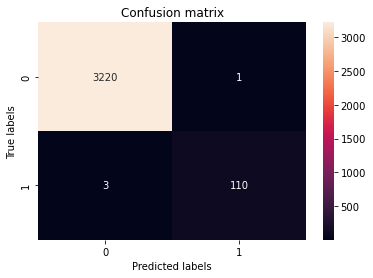

Confusion Matrix: 
 None



In [48]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, Y_train)

print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=False)

# Random Forest

Train Result:
Balanced Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    6440.0  226.0       1.0     6666.0        6666.0
_______________________________________________
Balanced accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6440
           1       1.00      1.00      1.00       226

    accuracy                           1.00      6666
   macro avg       1.00      1.00      1.00      6666
weighted avg       1.00      1.00      1.00      6666



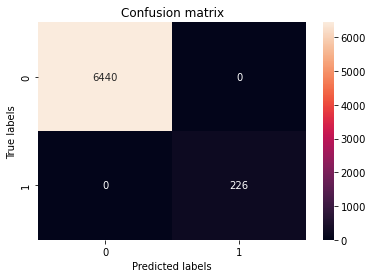

Confusion Matrix: 
 None

Test Result:
Balanced Accuracy Score: 98.67%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.999069    1.000000    0.9991     0.999535      0.999101
recall        1.000000    0.973451    0.9991     0.986726      0.999100
f1-score      0.999535    0.986547    0.9991     0.993041      0.999094
support    3221.000000  113.000000    0.9991  3334.000000   3334.000000
_______________________________________________
Balanced accuracy score: 0.9867256637168141
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       1.00      0.97      0.99       113

    accuracy                           1.00      3334
   macro avg       1.00      0.99      0.99      3334
weighted avg       1.00      1.00      1.00      3334



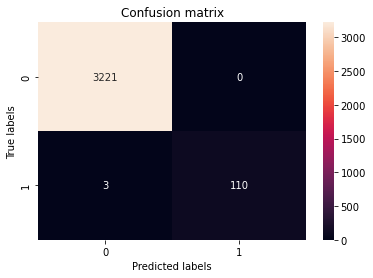

Confusion Matrix: 
 None



In [49]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, Y_train)

print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=True)
print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=False)

# Gradient Boosting Classifier

Test Result:
Balanced Accuracy Score: 98.66%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.999069    0.990991    0.9988     0.995030      0.998795
recall        0.999690    0.973451    0.9988     0.986570      0.998800
f1-score      0.999379    0.982143    0.9988     0.990761      0.998795
support    3221.000000  113.000000    0.9988  3334.000000   3334.000000
_______________________________________________
Balanced accuracy score: 0.9865704324221851
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3221
           1       0.99      0.97      0.98       113

    accuracy                           1.00      3334
   macro avg       1.00      0.99      0.99      3334
weighted avg       1.00      1.00      1.00      3334



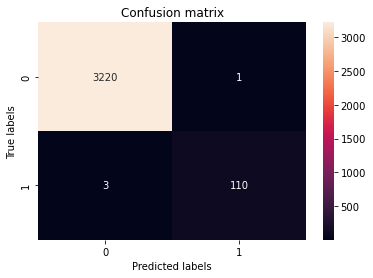

Confusion Matrix: 
 None



In [50]:
gbm = GradientBoostingClassifier(n_estimators = 200, max_features = 0.7, learning_rate = 0.3, max_depth = 5, 
                                 random_state = 0, verbose = 0)

gbm.fit(X_train, Y_train)

y_pred = gbm.predict(X_test)

print_score(gbm, X_train, Y_train, X_test, Y_test, train=False)

In [51]:
names = ["LogisticRegression", 
         "Decision_Tree", "Random_Forest", 'Gradient_Boosting']

classifiers = [
    LogisticRegression(solver='liblinear', class_weight='balanced'),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    GradientBoostingClassifier(n_estimators=150, learning_rate=1.0)
]


In [52]:
from sklearn.metrics import balanced_accuracy_score

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    score = balanced_accuracy_score(Y_test, y_pred)
    scores.append(score)

In [53]:
scores

[0.9867256637168141,
 0.9865704324221851,
 0.9867256637168141,
 0.9594008346772975]

# Analysis of Model Performaces

In [54]:
models = pd.DataFrame()
models['Name'] = names
models['Balanced Accuracy Score'] = scores
models

,Name,Balanced Accuracy Score
0,LogisticRegression,0.986726
1,Decision_Tree,0.986570
2,Random_Forest,0.986726
3,Gradient_Boosting,0.959401


In [55]:
cm = sns.light_palette("green", as_cmap=True)
s = models.style.background_gradient(cmap=cm)
s

,Name,Balanced Accuracy Score
0,LogisticRegression,0.986726
1,Decision_Tree,0.986570
2,Random_Forest,0.986726
3,Gradient_Boosting,0.959401


# Bar Plot of Model Performances

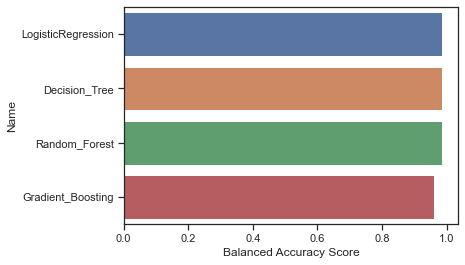

In [56]:
sns.set(style='ticks')
ax = sns.barplot(y='Name',x='Balanced Accuracy Score',data=models)